Actions received by class: 5
Physical action taken 0:  0
Physical action taken 1:  3
agent 0 is ongoing!
win status agent 0 = False
agent 1 is ongoing!
win status agent 1 = False
wins all agent situation in the environment: [False, False]
agent0 not hit !!!!!
agent1 not hit !!!!!
Physical action taken 0:  4
Physical action taken 1:  5
agent 0 is ongoing!
win status agent 0 = False
agent 1 is ongoing!
win status agent 1 = False
wins all agent situation in the environment: [False, False]
agent0 not hit !!!!!
agent1 not hit !!!!!
Physical action taken 0:  1
Physical action taken 1:  4
agent 0 is ongoing!
win status agent 0 = False
agent 1 is ongoing!
win status agent 1 = False
wins all agent situation in the environment: [False, False]
agent0 not hit !!!!!
agent1 not hit !!!!!
Physical action taken 0:  2
Physical action taken 1:  5
agent 0 is ongoing!
win status agent 0 = False
agent 1 is ongoing!
win status agent 1 = False
wins all agent situation in the environment: [False, False]
agent

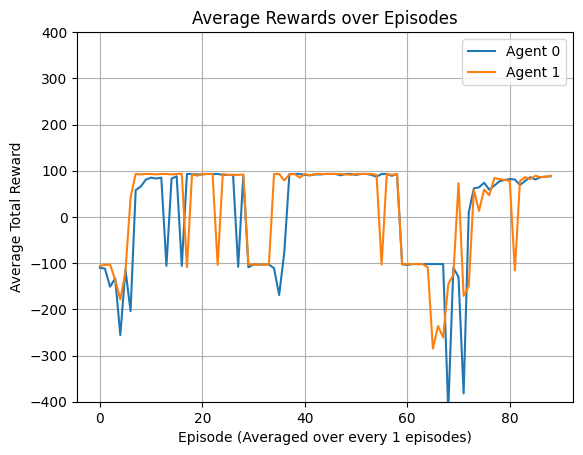

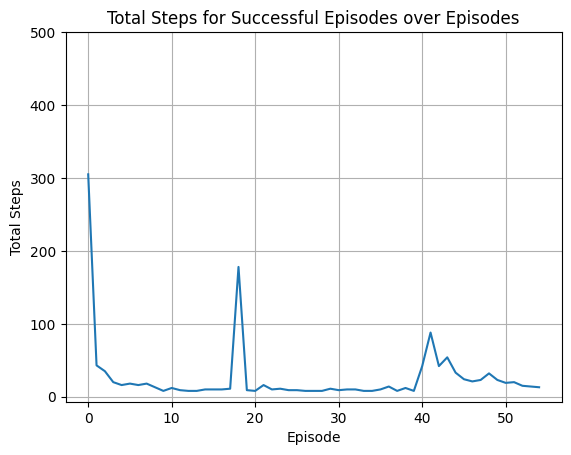

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import defaultdict
from environment_ma_reward_distance_dynamic_notrandom import Env

class QLearningAgent:
    def __init__(self, env, actions, lambda_val=0.8):
        print(f"Actions received by class: {actions}")
        self.env = env
        self.actions = actions
        self.communication_action = actions  # Define the communication action as the last action
        self.learning_rate = 0.1  
        self.discount_factor = 0.9
        self.epsilon = 0.1  
        self.epsilon_decay = 0.995  
        self.epsilon_min = 0.01  
        self.lambda_val = lambda_val  # Lambda value for eligibility traces
        self.q_tables = [defaultdict(lambda: [0.0] * (actions + 1)) for _ in range(env.num_agents)]  # Include communication action
        self.eligibility_traces = [defaultdict(lambda: [0.0] * (actions + 1)) for _ in range(env.num_agents)]  # Eligibility traces table
        self.rewards_per_episode = [[] for _ in range(env.num_agents)] 
        self.successful_episodes = [0] * env.num_agents  
        self.total_successful_episodes = 0

    def learn(self, agent_idx, state, physical_action, reward, next_state, comm_action):
        physical_state = tuple(state[0])
        physical_next_state = tuple(next_state[0])

        # Calculate TD error
        current_q = self.q_tables[agent_idx][physical_state][physical_action]
        max_next_q = max(self.q_tables[agent_idx][physical_next_state])
        td_error = reward + self.discount_factor * max_next_q - current_q

        # Update eligibility trace for the taken action
        self.eligibility_traces[agent_idx][physical_state][physical_action] += 1

        # Update Q-values for all state-action pairs
        for s in self.q_tables[agent_idx]:
            for a in range(len(self.q_tables[agent_idx][s])):
                self.q_tables[agent_idx][s][a] += self.learning_rate * td_error * self.eligibility_traces[agent_idx][s][a]
                # Decay eligibility trace
                self.eligibility_traces[agent_idx][s][a] *= self.discount_factor * self.lambda_val

        # Update q-table with communication action if it's not None
        if comm_action is not None:
            print(f"Agent {agent_idx} sends message: {comm_action}")
            self.update_from_communication(agent_idx, state, comm_action)

    def update_from_communication(self, agent_idx, state, comm_action):
        # Update Q-table based on received communication
        received_q_values = comm_action['q_values']  # Received Q-values from another agent
        state = tuple(state[0])
        for action, q_value in enumerate(received_q_values):
            self.q_tables[agent_idx][state][action] = max(self.q_tables[agent_idx][state][action], q_value)

    def print_q_table(self, agent_id):
        print(f"Q-table for Agent {agent_id}:")
        for state, actions in self.q_tables[agent_id].items():
            print(f"  State: {state}")
            for action, q_value in enumerate(actions):
                print(f"    Action: {action}, Q-value: {q_value:.5f}")
        print(f"End of Q-table for Agent {agent_id}\n")

    def get_action(self, agent_idx, state):
        physical_state = tuple(state[0])
        if np.random.rand() < self.epsilon:
            action = np.random.choice(self.actions)
        else:
            state_action = self.q_tables[agent_idx][physical_state]
            action = self.arg_max(state_action)
        return action

    def choose_action(self, agent_idx, state):
        physical_action = self.get_action(agent_idx, state)
        communication_action = None

        if not self.env.is_agent_silent and np.random.rand() < 0.1:  # 10% chance to communicate
            communication_action = self.get_communication_action(agent_idx, state)
        
        return (physical_action, communication_action)

    def get_communication_action(self, agent_idx, state):
        # Create a message with Q-values of the current state
        state = tuple(state[0])
        q_values = self.q_tables[agent_idx][state]
        return {'q_values': q_values}  # Example message containing Q-values

    @staticmethod
    def arg_max(state_action):
        max_index_list = []
        max_value = state_action[0]
        for index, value in enumerate(state_action):
            if value > max_value:
                max_index_list.clear()
                max_value = value
                max_index_list.append(index)
            elif value == max_value:
                max_index_list.append(index)
        return random.choice(max_index_list)

    def run_episodes(self, num_episodes):
        success_steps = []

        for episode in range(num_episodes):
            states = self.env.reset()
            episode_reward = [0] * self.env.num_agents  
            step_count = 0
            dones = [False] * self.env.num_agents
            win_states = [False] * self.env.num_agents
            success_episode = False
            success_count = [0] * self.env.num_agents  

            while not(all(dones)):
                combination_actions = []
                
                for agent_idx in range(self.env.num_agents):
                    state = states[agent_idx]
                    physical_action, comm_action = self.choose_action(agent_idx, state)
                    combination_actions.append((physical_action, comm_action))
                    print(f"Physical action taken {agent_idx}:  {physical_action}")

                next_states, rewards, dones = self.env.step(combination_actions)
                win_states = []
                for agent_idx in range(self.env.num_agents):
                    physical_action = combination_actions[agent_idx][0]
                    comm_action = combination_actions[agent_idx][1]
                    state = states[agent_idx]
                    reward = rewards[agent_idx]
                    next_state = next_states[agent_idx]
                    done = dones[agent_idx]
                    win_state = next_state[1]

                    self.learn(agent_idx, state, physical_action, reward, next_state, comm_action)

                    if win_state:
                        success_count[agent_idx] += 1
                        print(f"agent{agent_idx} hit !!!!!")
                    else:
                        print(f"agent{agent_idx} not hit !!!!!")

                    episode_reward[agent_idx] += reward
                    win_states.append(win_state)  

                step_count += 1
                states = next_states
                self.env.render()
                
            if self.env.win_flag:
                self.total_successful_episodes += 1
                success_steps.append(step_count)
                success_episode = True

            for agent_idx in range(self.env.num_agents):
                self.rewards_per_episode[agent_idx].append(episode_reward[agent_idx])
            
            print(f"Episode: {episode + 1}, Total Steps: {step_count}, Total Rewards: {episode_reward}, Status Episode: {success_episode}")
            print("--------------------")
            self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)

        overall_success_rate = self.total_successful_episodes / num_episodes * 100
        print(f"Overall Success Rate: {overall_success_rate}%")
        self.plot_rewards_per_episode(self.rewards_per_episode)
        self.plot_success_steps(success_steps)

    def plot_rewards_per_episode(self, rewards, window=1):
        for agent_idx in range(self.env.num_agents):
            # Calculate the moving average of rewards over the specified window size
            moving_avg_rewards = [np.mean(rewards[agent_idx][i:i + window]) for i in range(0, len(rewards[agent_idx]), window)]
            
            plt.plot(moving_avg_rewards, label=f'Agent {agent_idx}')
        
        plt.xlabel(f'Episode (Averaged over every {window} episodes)')
        plt.ylabel('Average Total Reward')
        plt.title('Average Rewards over Episodes')
        plt.legend()
        plt.ylim(-400, 400)
        plt.grid(True)
        plt.show()

    @staticmethod
    def plot_success_steps(success_steps):
        plt.plot(success_steps)
        plt.xlabel('Episode')
        plt.ylabel('Total Steps')
        plt.title('Total Steps for Successful Episodes over Episodes')
        plt.ylim(top=500)
        plt.grid(True)
        plt.show()

if __name__ == "__main__":
    num_agents = 2
    num_obstacles = 3
    obstacles_random_steps = 30
    is_agent_silent = False
    episodes=89
    max_steps=500
    alpha=0.1
    gamma=0.9
    epsilon=0.1
    epsilon_decay = 0.995  
    epsilon_min = 0.01  
    render = True

    env = Env(num_agents=num_agents, num_obstacles=num_obstacles, obstacles_random_steps = obstacles_random_steps, is_agent_silent=is_agent_silent)
    num_actions = len(env.action_space)
    agent = QLearningAgent(env, num_actions)

    agent.run_episodes(episodes)
